In [12]:
root_path = '/content/drive/My Drive/Colab Notebooks/Paper/EXP/'
expr_path = root_path + 'Benchmark/MNIST/sMNIST/LSTM'

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import sys
import_path = [root_path + subpath for subpath in ['sources/', 'sources/expRNN/']]
for path in import_path:
  sys.path.append(path)

In [15]:
import sys
import argparse
sys.argv = ['']
parser = argparse.ArgumentParser(description='LSTM MNIST Task')
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--hidden_size', type=int, default=170)
parser.add_argument('--epochs', type=int, default=70)
parser.add_argument('--use_adam', type=bool, default=False)
parser.add_argument('--adam_lr', type=float, default=1e-3)
parser.add_argument('--rmsprop_lr', type=float, default=7e-4)
parser.add_argument('--rmsprop_constr_lr', type=float, default=7e-5)
parser.add_argument('--alpha', type=float, default=0.99)
parser.add_argument('--clip_norm', type=float, default=-1)
parser.add_argument("--permute", action="store_true", default = False)
parser.add_argument("-m", "--mode",
                    choices=["exprnn", "dtriv", "cayley", "lstm", "rnn"],
                    default="exprnn",
                    type=str)
parser.add_argument('--K', type=str, default="100", help='The K parameter in the dtriv algorithm. It should be a positive integer or "infty".')
parser.add_argument("--init",
                    choices=["cayley", "henaff"],
                    default="cayley",
                    type=str)
parser.add_argument('--random-seed', type=int, default=5544,
                    help='random seed')
parser.add_argument('--rho_rat_den', type=int, default=10)
parser.add_argument('--forget_bias', type=int, default=1)
parser.add_argument('--emsize', type=int, default=0,
                    help='size of word embeddings')
#Setting
args = parser.parse_args(['--hidden_size', '128', '--epochs', '70', '--rmsprop_lr', '1e-3', '--alpha', '0.9', '--clip_norm', '1', '-mlstm'])
print(args)

Namespace(K='100', adam_lr=0.001, alpha=0.9, batch_size=128, clip_norm=-1, clip_val=1.0, emsize=0, epochs=70, forget_bias=1, hidden_size=128, init='cayley', mode='lstm', permute=False, random_seed=5544, rho_rat_den=10, rmsprop_constr_lr=7e-05, rmsprop_lr=0.001, use_adam=False)


In [16]:
import torch
import numpy as np
import random
import os
# Fix seed across experiments
# Same seed as that used in "Orthogonal Recurrent Neural Networks with Scaled Cayley Transform"
# https://github.com/SpartinStuff/scoRNN/blob/master/scoRNN_copying.py#L79
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(args.random_seed)
np.random.seed(args.random_seed)
random.seed(args.random_seed)

#Deterministic training
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8" #increase library footprint in GPU memory by approximately 24MiB
#os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8" #(may limit overall performance)"

In [17]:
from trivializations import cayley_map, expm
from initialization import henaff_init_, cayley_init_
from data_module import MNISTDataModule
from torch.nn import Embedding

sequence_length = 784
hidden_size = args.hidden_size
batch_size  = args.batch_size
epochs      = args.epochs
device      = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_first = True
many_to_many = False
epochs_to_save = 1

if args.init == "cayley":
    init =  cayley_init_
elif args.init == "henaff":
    init = henaff_init_

if args.K != "infty":
  args.K = int(args.K)
if args.mode == "exprnn":
  mode = "static"
  param = expm
elif args.mode == "dtriv":
  # We use 100 as the default to project back to the manifold.
  # This parameter does not really affect the convergence of the algorithms, even for K=1
  mode = ("dynamic", args.K, 100)
  param = expm
elif args.mode == "cayley":
  mode = "static"
  param = cayley_map
else:
  mode = None
  param = None

#Setting up data module
# Load data   
dataset_path = root_path + 'Dataset/MNIST/'
if args.permute:
  datamodule = MNISTDataModule(sequence_length, 784 // sequence_length, batch_size, dataset_path, permute_seed = 92916)
else:
  datamodule = MNISTDataModule(sequence_length, 784 // sequence_length, batch_size, dataset_path, permute_seed = None)

if args.emsize > 0:
  embed_layer = Embedding(datamodule.input_size, args.emsize) # Token2Embeddings
  input_size = args.emsize
else:
  embed_layer = None
  input_size = datamodule.input_size

In [18]:
from model_loader import Model
from custom_modules import AMSAF_SVD
from orthogonal import modrelu

#Initialize Model
nonlinearity = modrelu(hidden_size)
model = Model(input_size, hidden_size, datamodule.output_size, nonlinearity, initializer_skew = init,
              mode = mode, param = param, args=args, embed_layer=embed_layer, batch_first=batch_first, many_to_many = many_to_many).to(device)
#Initialize Optimizers
unconstrained_parameters = []
constrained_parameters = []

for name, p in model.named_parameters():
    if any(map(name.__contains__, ['recurrent_kernel'])):
        constrained_parameters.append(p)
    else:
        unconstrained_parameters.append(p)
if args.use_adam:
  adam_optim = torch.optim.Adam(unconstrained_parameters, lr=args.adam_lr)
  rmsprop_optim = torch.optim.RMSprop(constrained_parameters, lr=args.rmsprop_constr_lr)
else:
  rmsprop_optim = torch.optim.RMSprop([
                  {'params': unconstrained_parameters},
                  {'params': constrained_parameters, 'lr': args.rmsprop_constr_lr}
              ], lr=args.rmsprop_lr, alpha = args.alpha)
  adam_optim = None

optim_list = [optim for optim in [rmsprop_optim, adam_optim] if optim]
model.setup_optimizer_list(optim_list)

column_names = ['Epoch', 'Training Loss', 'Training Accuracy', 'Test Loss', 'Test Accuracy']
train_log = model.load_log_df(epochs_to_save, expr_path, column_names)

In [19]:
def pred(model, datamodule, training = True):
  global device
  total_loss = 0.0
  total_acc = 0.0
  sample_num = 0

  if training:
    data_enum = datamodule.train_enum()
    data_len = datamodule.train_len
  else:
    data_enum = datamodule.test_enum()
    data_len = datamodule.test_len

  for batch_x, batch_y in data_enum:
      batch_x, batch_y = batch_x.to(device).view(-1, datamodule.sequence_length, datamodule.input_size), batch_y.to(device)
      state = None
      state = model.state_reprocess(batch_x, state)

      logits = model.compute_logits(batch_x, state)
      loss = model.loss(logits, batch_y)
      if training:
        model.gradient_descent(loss)
      total_loss += loss.item() * batch_x.size(0)
      batch_correct = model.correct(logits, batch_y).item()
      total_acc += batch_correct
      sample_num += batch_x.size(0)
      
      if training: #For tracking training progress
        print('Train Epoch: {} [{}/{} ({:.2f}%)]\tBatch Loss: {:.3f}\t\tBatch Accuracy: {:.2f}%'.format(model.step+1, sample_num, datamodule.train_len,
                    model.average_value(100. * sample_num, datamodule.train_len, 2), loss.item(), model.average_value(100 * batch_correct, len(batch_x), 2)))
        
  total_loss = model.average_value(total_loss, data_len, 3)
  total_acc = model.average_value(100 * total_acc, data_len, 2)
  return total_loss, total_acc

In [20]:
def save_model(epochs_to_save, experiment_path):
  if (model.step % epochs_to_save == 0):
    if ((model.step // epochs_to_save) % 2) == 1:
      model.save_state(experiment_path+'/last_odd.ckpt')
    else:
      model.save_state(experiment_path+'/last_even.ckpt')

In [21]:
import pandas as pd
#Training
model.train()
for epoch in range(model.step+1, epochs):
  train_loss, train_acc = pred(model, datamodule, training = True)
  print('Train Epoch {}| Loss: {:.3f}\tAccuracy: {:.2f}%'.format(epoch, train_loss, train_acc))

  model.eval()
  with torch.no_grad():
      test_loss, test_acc = pred(model, datamodule, training = False)
  if len(train_log) == 0:
    best_test_acc = test_acc
  else:
    best_test_acc = max(train_log["Test Accuracy"].max(), test_acc)
  print('Test Epoch {}| Loss: {:.3f}\tAccuracy: {:.2f}%\tBest Accuracy: {:.2f}'.format(epoch, test_loss, test_acc, best_test_acc))       

  model.step = epoch #update_log_df and save_model requires this command
  new_row = pd.Series({"Epoch": epoch, "Training Loss": train_loss, "Training Accuracy": train_acc,
                        "Test Loss": test_loss, 'Test Accuracy': test_acc})
  train_log = model.update_log_df(new_row, train_log, expr_path+'/train_log.pkl')
  save_model(epochs_to_save, expr_path)
  model.train()

Streaming output truncated to the last 5000 lines.
Train Epoch: 59 [23296/60000 (38.83%)]	Batch Loss: 2.378		Batch Accuracy: 12.50%
Train Epoch: 59 [23424/60000 (39.04%)]	Batch Loss: 2.231		Batch Accuracy: 14.84%
Train Epoch: 59 [23552/60000 (39.25%)]	Batch Loss: 2.323		Batch Accuracy: 16.41%
Train Epoch: 59 [23680/60000 (39.47%)]	Batch Loss: 2.467		Batch Accuracy: 5.47%
Train Epoch: 59 [23808/60000 (39.68%)]	Batch Loss: 2.441		Batch Accuracy: 8.59%
Train Epoch: 59 [23936/60000 (39.89%)]	Batch Loss: 2.609		Batch Accuracy: 10.94%
Train Epoch: 59 [24064/60000 (40.11%)]	Batch Loss: 2.610		Batch Accuracy: 9.38%
Train Epoch: 59 [24192/60000 (40.32%)]	Batch Loss: 2.497		Batch Accuracy: 13.28%
Train Epoch: 59 [24320/60000 (40.53%)]	Batch Loss: 2.550		Batch Accuracy: 11.72%
Train Epoch: 59 [24448/60000 (40.75%)]	Batch Loss: 2.430		Batch Accuracy: 14.84%
Train Epoch: 59 [24576/60000 (40.96%)]	Batch Loss: 2.381		Batch Accuracy: 11.72%
Train Epoch: 59 [24704/60000 (41.17%)]	Batch Loss: 2.465		Bat

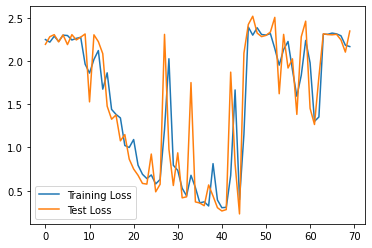

In [22]:
model.train_plot(train_log, 'Training Loss', 'Test Loss')

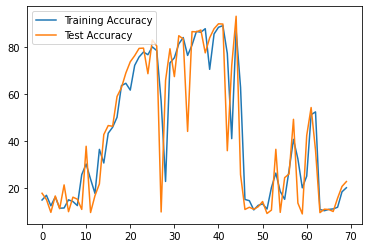

In [23]:
model.train_plot(train_log, 'Training Accuracy', 'Test Accuracy')